## Config

In [1]:
import sys
import os
import cv2
import imageio
import random
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sys.path.append("..")
from src.utils import load_config, print_config, set_seed

os.chdir("..")
print(os.getcwd())

/home/ionut/Projects/sdg4ad


In [2]:
cfg = load_config("config/config_synthetic_generation.yaml")
print_config(cfg)
set_seed(cfg["seed"])

Configuration:
seed: 42
file_paths: ['data/Splits/PN/split_1_train.txt', 'data/Splits/PN/split_2_train.txt', 'data/Splits/PN/split_3_train.txt']
output_paths: ['output/synthetic_images_PN/split_1', 'output/synthetic_images_PN/split_2', 'output/synthetic_images_PN/split_3']
plot: True
sam_checkpoint: weights/sam_vit_h_4b8939.pth
model_type: vit_h
device: cpu
points_per_side: 32
sigma: 5
partition: 50
lower_th_a: 80
upper_th_a: 160
lower_th_b: 80
upper_th_b: 240



## Canny

In [3]:
def get_index_of_edgiest_grape(cfg, imgs):
    """
    Returns the index of the edgiest grape in the list of images.
    
    It uses two Canny edge detectors with different thresholds and returns the index of the image
    with the highest difference in edge count. The edge count is normalized by the image size.

    Args:
        cfg (dict): Configuration dictionary.
        imgs (list): List of images.

    Returns:
        int: Index of the edgiest grape.
    """
    edge_counts = []
    for img in imgs:
        img = cv2.GaussianBlur(img, (cfg["sigma"], cfg["sigma"]), 0)
        num_edges_a = cv2.countNonZero(cv2.Canny(img, cfg["lower_th_a"], cfg["upper_th_a"]))
        num_edges_b = cv2.countNonZero(cv2.Canny(img, cfg["lower_th_b"], cfg["upper_th_b"]))
        non_black_pixels = np.count_nonzero(np.any(img != [0, 0, 0], axis=-1))
        normalized_edge_count = (num_edges_a - num_edges_b) / (non_black_pixels)
        edge_counts.append(normalized_edge_count)
    return np.argmax(edge_counts) 


## SAM

In [4]:
def resize_image(image_path, target_resolution):
    resolutions = {
    "720p": (1280, 720),
    "1080p": (1920, 1080),
    "1440p": (2560, 1440),
    "4k": (3840, 2160)
    }

    target_height, target_width = resolutions[target_resolution]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    aspect_ratio = width / height
    target_ratio = target_width / target_height

    if aspect_ratio > target_ratio:
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    return resized_image


def get_mask_generator(cfg):
    """
    Returns the SAM mask generator.
    
    Args:
        cfg (dict): The configuration dictionary.
        
    Returns:
        SamAutomaticMaskGenerator: The mask generator.
    """
    sam = sam_model_registry[cfg["model_type"]](checkpoint=cfg["sam_checkpoint"]).to(device=cfg["device"])
    mask_generator = SamAutomaticMaskGenerator(model=sam, points_per_side=cfg["points_per_side"])
    return mask_generator


def filter_masks_by_area(masks, partition):
    # Threhsholds
    grapes_area = np.array([mask['area'] for mask in masks])
    mu = np.mean(grapes_area)
    sigma = np.std(grapes_area)

    k_min=0.1
    k_max=0

    percent_new_masks=0
    while percent_new_masks<=partition and k_max<3:
        new_masks=[]
        k_max+=0.1
        min_mask_region_area = mu - k_min*sigma
        max_mask_region_area = mu + k_max*sigma

        # Filtraggio
        for elem in masks:
            if elem['area'] > min_mask_region_area and elem['area'] < max_mask_region_area:
                new_masks.append(elem)

        len_new_masks = len(new_masks)
        percent_new_masks=(len_new_masks*100)/len(masks)

    return new_masks


def generate_masks(image, mask_generator, partition):
    """
    Generates masks for the input image. The masks are filtered by area.
    
    Args:
        image (np.array): The input image.
        mask_generator (SamAutomaticMaskGenerator): The mask generator.
        partition (float): The partition of the area of the masks to keep.

    Returns:
        list: The generated masks.
    """
    masks = mask_generator.generate(image)
    masks = filter_masks_by_area(masks, partition)
    masks = [mask['segmentation'] for mask in masks]
    return masks

## Utils

In [5]:
def read_file_list(file_path):
  """
  Reads the file list and returns the paths of the good and bad grapes.

  Args:
      file_path (str): The path to the file list.

  Returns:
      list: The paths of the good grapes.
      list: The paths of the bad grapes.
  """
  good_paths = []
  bad_paths = []
  with open(file_path, 'r') as file:
      for line in file:
          path, label = line.strip().split()
          if label == '0':  # Good grape
              good_paths.append(path)
          else:  # Grape with anomaly
              bad_paths.append(path)
  return good_paths, bad_paths


def write_log(index, good_image_path, bad_image_path, log_folder):
    """
    Writes the log of the generated anomaly.

    Args:
        index (int): The index of the anomaly.
        good_image_path (str): The path of the good grape image.
        bad_image_path (str): The path of the bad grape image.
        log_folder (str): The path of the log folder.
    """
    log_folder = os.path.join(log_folder, "logs")
    os.makedirs(log_folder, exist_ok=True)
    with open(os.path.join(log_folder, f"log_anomaly_{index}.txt"), "a") as f:
        f.write(f"Anomaly {index} generated with:\n")
        f.write(f"Good image: {os.path.basename(good_image_path)}\n")
        f.write(f"Bad image: {os.path.basename(bad_image_path)}\n")


def get_biggest_component(mask):
    """
    Returns the biggest component of the mask.

    Args:
        mask (np.array): The input mask.

    Returns:
        np.array: The biggest component of the mask.
    """
    _, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    return (labels == largest_label).astype(np.uint8)


def save_segmentations(img, masks, output_folder):
    """
    Saves the segmentations of the input image.

    Args:
        img (np.array): The input image.
        masks (list): The list of masks.
        output_folder (str): The output folder.
    """
    os.makedirs(output_folder, exist_ok=True)
    for i, mask in enumerate(masks):
        mask = mask.astype(np.uint8)
        mask = get_biggest_component(mask)
        imageio.imwrite(os.path.join(output_folder, f"segmented_{i}.png"), np.dstack((img, mask*255)))

## Blending

In [6]:
def PoissonBlending(source, destination, bad_mask, good_mask, cloning_type, plot=False):
    """
    Blends the source image with the destination image using Poisson blending.

    Args:
        source (np.array): The source image.
        destination (np.array): The destination image.
        bad_mask (np.array): The mask of the bad grape.
        good_mask (np.array): The mask of the good grape.
        cloning_type (int): The type of cloning.

    Returns:
        np.array: The blended image.
    """
    # Get dimensions of the bad mask
    x_bad, y_bad, w_bad, h_bad = cv2.boundingRect(bad_mask)
    center_bad = (x_bad + w_bad // 2, y_bad + h_bad // 2)

    # Set the center for the blending to be the centroid of the good grape
    moments = cv2.moments(good_mask)
    center_good = (int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00']))

    # Calculate offset for aligning bad mask with good mask centroid
    offset = (center_good[0] - center_bad[0], center_good[1] - center_bad[1])

    # # Move the bad grape to the centroid of the good mask
    M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    bad_mask = cv2.warpAffine(bad_mask, M, (destination.shape[1], destination.shape[0]), flags=cv2.INTER_NEAREST)
    source = cv2.warpAffine(source, M, (destination.shape[1], destination.shape[0]))

    if plot:
        _, ax = plt.subplots(1, 2)
        ax[0].imshow(source)
        ax[0].set_title("Bad grape aligned")
        ax[1].imshow(bad_mask)
        ax[1].set_title("Bad mask aligned")
        plt.show()

    # # Get the intersection of the aligned masks
    intersection = cv2.bitwise_and(bad_mask, good_mask)

    if plot:
        plt.imshow(intersection)
        plt.title("Intersection")
        plt.show()

    # Get the bounding box of the intersection
    _, _, w_inter, h_inter = cv2.boundingRect(intersection)

    # Add padding around destination to make sure that the source will not be outside the image
    destination = cv2.copyMakeBorder(destination, h_inter, h_inter, w_inter, w_inter, cv2.BORDER_REFLECT101)
    center_good = (center_good[0] + w_inter, center_good[1] + h_inter)

    # Poisson blending
    blended = cv2.seamlessClone(source, destination, intersection*255, center_good, cloning_type)

    # Remove the padding
    blended = blended[h_inter:-h_inter, w_inter:-w_inter]

    if plot:
        save_segmentations(blended, [intersection], "./notebooks/output")

    return blended

## Rotation and Scaling

In [7]:
def get_rotation_matrix(mask, reference_mask, plot=False):
    """
    Returns the rotation matrix to align the principal axes of the mask with the reference mask.

    Args:
        mask (np.array): The mask to align.
        reference_mask (np.array): The reference mask.
        plot (bool): Whether to plot the masks and the principal axes.

    Returns:
        np.array: The rotation matrix.
    """    
    # Find indices of non-zero elements (row, column) -> (y, x)
    mask_points = np.argwhere(mask)
    ref_points = np.argwhere(reference_mask)

    # Fit PCA on mask and reference mask points
    pca = PCA(n_components=2)
    pca.fit(mask_points)
    ref_pca = PCA(n_components=2)
    ref_pca.fit(ref_points)

    # Get primary principal components from PCA (y,x)
    principal_axis = pca.components_[0]
    ref_principal_axis = ref_pca.components_[0]

    
    # Only consider the direction of the principal axis in the positive y direction
    if principal_axis[0] < 0:
        principal_axis = -principal_axis
    if ref_principal_axis[0] < 0:
        ref_principal_axis = -ref_principal_axis

    # Compute angles of principal axes (positive -> clockwise)
    angle = np.rad2deg(np.arctan2(principal_axis[0], principal_axis[1]))
    ref_angle = np.rad2deg(np.arctan2(ref_principal_axis[0], ref_principal_axis[1]))
    
    # Compute rotation angle 
    rotation_angle = ref_angle - angle

    # Get rotation matrix
    moments = cv2.moments(mask)
    center = (moments['m10'] / moments['m00'], moments['m01'] / moments['m00'])
    rotation_matrix = cv2.getRotationMatrix2D(center, -rotation_angle, 1.0)  # positive angle -> counter-clockwise

    if plot:
        print("Principal axis:", principal_axis)
        print("Reference principal axis:", ref_principal_axis)
        print("Angle:", angle)
        print("Reference angle:", ref_angle)
        print("Rotation angle:", rotation_angle)

        _, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Show the mask and the direction of the principal axes
        axs[0].imshow(mask, cmap="gray")
        axs[0].set_title("Mask") 
        axs[0].quiver(center[0], center[1], principal_axis[1], -principal_axis[0], color="green", scale=5)

        # Show the reference mask and the direction of the principal axes
        ref_moments = cv2.moments(reference_mask)
        center_reference = (ref_moments['m10'] / ref_moments['m00'], ref_moments['m01'] / ref_moments['m00'])
        axs[1].imshow(reference_mask, cmap="gray")
        axs[1].set_title("Reference mask")
        axs[1].quiver(center_reference[0], center_reference[1], ref_principal_axis[1], -ref_principal_axis[0], color="green", scale=5)
        plt.show()

    return rotation_matrix


def rotate_grape(image, mask, reference_mask, plot=False):
    """
    Rotates the grape (image and mask) to align the principal axes of the mask with the reference mask.

    Args:
        image (np.array): The image of the grape.
        mask (np.array): The mask of the grape.
        reference_mask (np.array): The reference mask.
        plot (bool): Whether to plot the principal axes.

    Returns:
        np.array: The rotated image.
        np.array: The rotated mask.
    """
    # Get rotation matrix
    rotation_matrix = get_rotation_matrix(mask, reference_mask, plot)

    # Rotate the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

    # Rotate the mask
    rotated_mask = cv2.warpAffine(mask, rotation_matrix, (mask.shape[1], mask.shape[0]), flags=cv2.INTER_NEAREST)

    if plot:
        _, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(rotated_image)
        axs[0].set_title("Rotated image")
        axs[1].imshow(rotated_mask, cmap="gray")
        axs[1].set_title("Rotated mask")
        plt.show()

    return rotated_image, rotated_mask


def scale_grape(image, mask, reference_mask, plot=False):
    """
    Scales the grape (image and mask) to match the size of the reference mask.

    Args:
        image (np.array): The image of the grape.
        mask (np.array): The mask of the grape.
        reference_mask (np.array): The reference mask.
        plot (bool): Whether to plot the masks.

    Returns:
        np.array: The scaled image.
        np.array: The scaled mask.
    """
    # Compute moments
    moments = cv2.moments(mask)
    ref_moments = cv2.moments(reference_mask)

    # Compute the scale factor
    scale_factor = np.sqrt(ref_moments['m00'] / moments['m00'])

    # Scale the image
    img_interp = cv2.INTER_CUBIC if scale_factor > 1 else cv2.INTER_AREA
    scaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=img_interp)

    # Scale the mask
    scaled_mask = cv2.resize(mask, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)

    if plot:
        _, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(scaled_image)
        axs[0].set_title("Scaled image")
        axs[1].imshow(scaled_mask, cmap="gray")
        axs[1].set_title("Scaled mask")
        plt.show()

    return scaled_image, scaled_mask


## Main

In [8]:
def generate_synthetic_image(cfg, img_good, img_bad, mask_generator):
    """
    Generates a synthetic image by blending a bad grape onto an image of good grapes.

    Args:
        cfg (dict): Configuration dictionary.
        img_good (np.array): The image of good grapes.
        img_bad (np.array): The image of bad grapes.
        mask_generator (SamAutomaticMaskGenerator): The mask generator.
        plot (bool): Whether to plot the intermediate steps.

    Returns:
        np.array: The synthetic image.
    """
    # Generate masks for the good image and choose one randomly
    good_masks = generate_masks(img_good, mask_generator, cfg["partition"])
    good_idx = random.randint(0, len(good_masks) - 1)
    good_mask = good_masks[good_idx].astype(np.uint8)

    if cfg["plot"]:
        good_grape = img_good * good_mask[:,:,None]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(good_mask)
        plt.title("Good mask")
        plt.subplot(1, 2, 2)
        plt.imshow(good_grape)
        plt.title("Good grape")
        plt.show()

    # Generate masks for the bad image and choose the edgiest one
    bad_masks = generate_masks(img_bad, mask_generator, cfg["partition"])
    bad_grapes = [img_bad * mask[:,:,None] for mask in bad_masks]
    bad_idx = get_index_of_edgiest_grape(cfg, bad_grapes)
    bad_mask = bad_masks[bad_idx].astype(np.uint8)
    bad_grape = bad_grapes[bad_idx]

    # Check if the masks are made of more than one connected component
    bad_mask = get_biggest_component(bad_mask)
    good_mask = get_biggest_component(good_mask)        

    # Rotate the bad grape to match the orientation of the good grape
    bad_grape, bad_mask = rotate_grape(bad_grape, bad_mask, good_mask, cfg["plot"])

    # Scale the bad grape to match the size of the good grape
    bad_grape, bad_mask = scale_grape(bad_grape, bad_mask, good_mask, cfg["plot"])

    # Blend the bad grape onto the good image
    blended = PoissonBlending(bad_grape, img_good, bad_mask, good_mask, cv2.NORMAL_CLONE, cfg["plot"])

    if cfg["plot"]:
        os.makedirs("./notebooks/inputs/", exist_ok=True)
        os.makedirs("./notebooks/output/", exist_ok=True)

        save_segmentations(img_good, good_masks, output_folder="./notebooks/good_masks/")
        save_segmentations(img_bad, bad_masks, output_folder="./notebooks/bad_masks/")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(bad_mask)
        plt.title("Bad mask")
        plt.subplot(1, 2, 2)
        plt.imshow(bad_grape)
        plt.title("Bad grape")
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.imshow(blended)
        plt.title("Blended image")
        plt.show()

        imageio.imsave("./notebooks/inputs/good_grape.jpg", img_good)
        imageio.imsave("./notebooks/inputs/bad_grape.jpg", img_bad)
        imageio.imsave("./notebooks/output/blended.jpg", blended)
        
    return blended

Processing images:   0%|          | 0/260 [00:00<?, ?it/s]

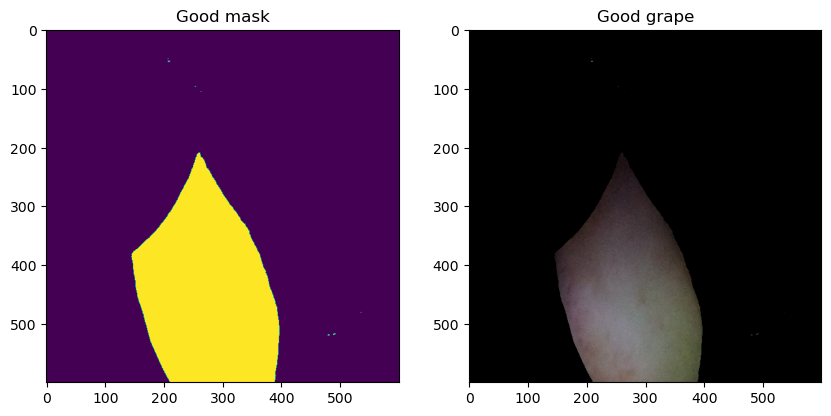

Principal axis: [0.90218087 0.43135794]
Reference principal axis: [0.97808175 0.20822125]
Angle: 64.44623053496845
Reference angle: 77.98186664639952
Rotation angle: 13.535636111431074


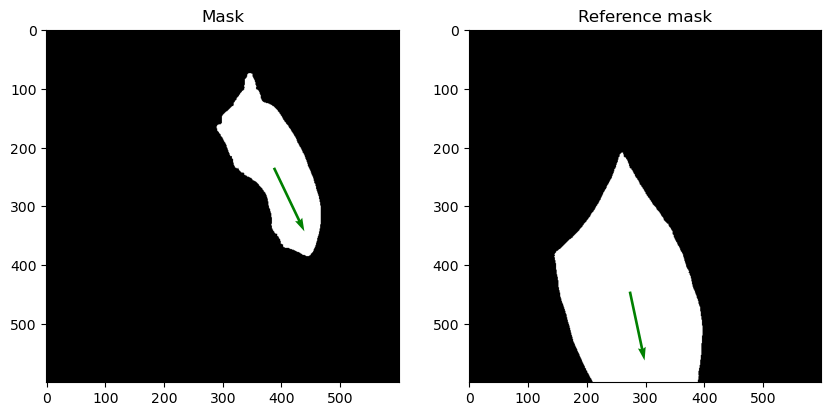

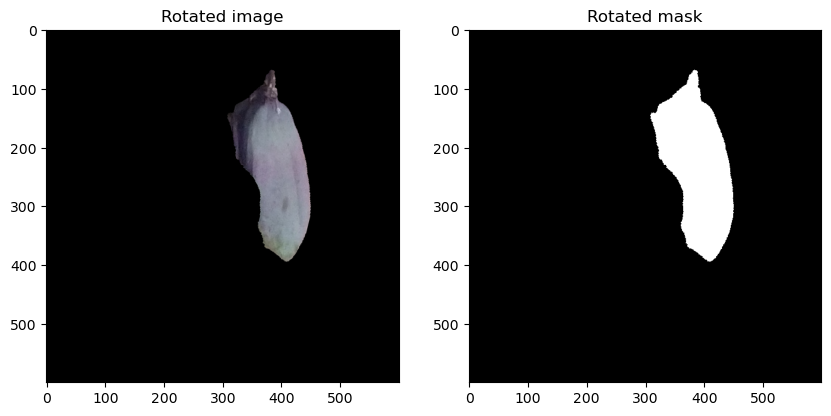

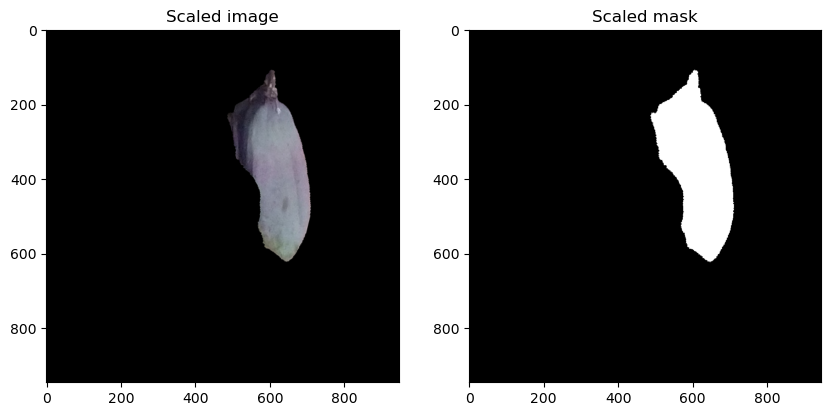

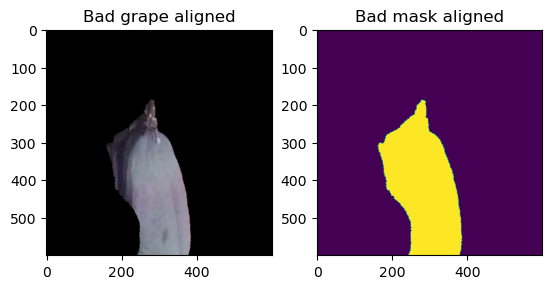

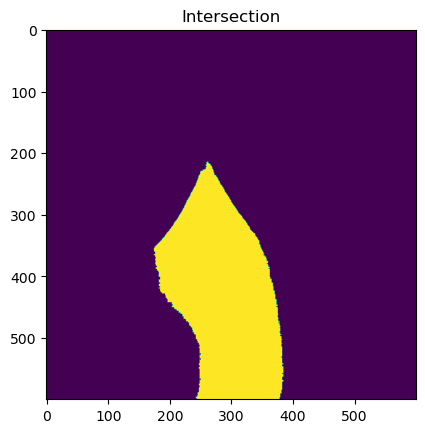

Processing images:   0%|          | 0/260 [02:02<?, ?it/s]


NameError: name 'img_segmented' is not defined

In [9]:
mask_generator = get_mask_generator(cfg)
good_image_paths, bad_image_paths = read_file_list(cfg["file_paths"][0])
log_folder = os.path.join(cfg["output_paths"][0], "logs")
os.makedirs(log_folder, exist_ok=True)

num_good_images = len(good_image_paths)
num_bad_images = len(bad_image_paths)
for index, good_image_path in tqdm(enumerate(good_image_paths), desc="Processing images", total=num_good_images):
    bad_image_path = bad_image_paths[index % num_bad_images]

    img_good = cv2.imread(good_image_path)
    img_good = cv2.cvtColor(img_good, cv2.COLOR_BGR2RGB)

    img_bad = cv2.imread(bad_image_path)
    img_bad = cv2.cvtColor(img_bad, cv2.COLOR_BGR2RGB)

    # img_good = resize_image(good_image_path, cfg["target_size"])
    # img_bad = resize_image(bad_image_path, cfg["target_size"])

    new_img = generate_synthetic_image(cfg, img_good, img_bad, mask_generator)
    
    write_log(index, good_image_path, bad_image_path, log_folder)
    imageio.imsave(f"{cfg['output_paths'][0]}/anomaly_{index}.jpg", new_img)

print("Synthetic images generated successfully!")